In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [2]:
class node:
    def __init__(self,name,hold,left,right):
        self.feature_name=name
        self.treshhold=hold
        self.left_data=left
        self.right_data=right
        self.features=None
        self.left_child=None
        self.right_child=None
    
    
class Btree:
    root=None
    
    def __init__(self,node1):
        self.root = node1

    def inser_node(self,child_node,child='left'):
        if(child=='left'):
            self.node.left_child = child_node
        else :
            self.node.right_child = child_node
    
    def inorder(self, root,node_list):
        if root is None:
            return
        self.inorder(root.left_child,node_list)
        #print(root.feature_name)
        node_list.append(root.feature_name)
        self.inorder(root.right_child,node_list)


    def print_tree(self):
        node_list=[]
        self.inorder(self.root,node_list)
        return node_list

In [3]:
data = load_breast_cancer(as_frame =True)
df = pd.DataFrame(data.frame)
features=df.columns.tolist()
size = 455+114
train_size = 455
test_size = size - train_size
x_train,x_test = train_test_split(df,test_size=0.2,random_state=20)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
features.remove('target')
print(len(features))


30


In [4]:
def entropy(target):
    size = len(target)
    yes=len(target[target==1])
    no = size-yes
    ent=0
    if yes > 0:
        ent -= (yes / size) * np.log2(yes / size)
    if no > 0:
        ent -= (no / size) * np.log2(no / size)
    return ent
    

In [5]:
def devide(data,thold,f):
    left = data[data[f]<thold]
    right = data[data[f]>=thold]
    t_size = len(data['target'])
    l_size = len(left['target'])
    r_size = len(right['target'])
    left_entropy=right_entropy=0
    if(l_size!=0):
        left_entropy = entropy(left['target'])
    if(r_size!=0):
        right_entropy = entropy(right['target'])

    
    etr = (l_size*left_entropy + r_size*right_entropy)/t_size
    return etr,left_entropy,right_entropy

In [6]:
def best_feature(features1,data):
    best_entropy=200
    best_feat=''
    best_hold=0
    best_left_entropy=best_right_entropy=float('inf')
    for f in features1:
        sort_df=data.sort_values(by=f)
        for i in range (1,len(sort_df['target'])):
            hold = (sort_df[f][i-1]+sort_df[f][i])/2
            ent,l,r = devide(sort_df,hold,f)
            if(ent<best_entropy):
                best_entropy=ent
                best_feat=f
                best_hold=hold
                best_left_entropy=l
                best_right_entropy=r
    
    return best_feat,best_hold,best_entropy,best_left_entropy,best_right_entropy

In [7]:
def construct_tree(data,features1,depth,depth_limit,diff,sample_size,parent_entropy):
    if(len(features1)==0 or depth>5):
        return None
    data = data.reset_index(drop=True)
    bf,hold,cur_entropy ,left_entropy,right_entropy= best_feature(features1,data)
    left_data = data[data[bf]<hold]
    right_data = data[data[bf]>=hold]
    root = node(bf,hold,left_data,right_data)
    #print(root.feature_name)
    features1.remove(bf)
    left_child=right_child=None
    #return root
    if(len(left_data['target'])>sample_size and (parent_entropy-cur_entropy)>diff):
        left_child = construct_tree(left_data,features1.copy(),depth+1,depth_limit,diff,sample_size,left_entropy)
    if(len(right_data['target'])>sample_size and (parent_entropy-cur_entropy)>diff):
        right_child = construct_tree(right_data,features1.copy(),depth+1,depth_limit,diff,sample_size,right_entropy)
    root.left_child=left_child
    root.right_child=right_child
    return root


In [8]:
def pred(sample,root):
    
    if((root.left_child is  None ) and(root.right_child is  None ) ) :

        f = root.feature_name
        if(sample[f]<root.treshhold):
            target = root.left_data['target']
        else :
            target = root.right_data['target']
        size = len(target)
        yes=len(target[target==1])
        no = size-yes
        return 1 if (yes>no) else 0
    else :
        f = root.feature_name
        if(sample[f]<root.treshhold  ):
            f = root.feature_name
            if(root.left_child is not None):
                res=pred(sample,root.left_child)
            else :
                target=root.left_data
                size = len(target)
                yes=len(target[target==1])
                no = size-yes
                return 1 if (yes>no) else 0
        
        if(sample[f]>=root.treshhold ):
            f = root.feature_name
            if(root.right_child is not None):
                res=pred(sample,root.right_child )
            else:
                target=root.right_data
                size = len(target)
                yes=len(target[target==1])
                no = size-yes
                return 1 if (yes>no) else 0
                
        return res

In [9]:
def predict(test_data,root):
    labels=[]
    test_data = test_data.reset_index(drop=True)
    for i in range (0,len(test_data)):
        sample = test_data.iloc[i]
        labels.append(pred(sample,root))
    accuracy = accuracy_score(labels,test_data['target'])
    return labels,accuracy
    

        


In [10]:
def cross_entropy(data,depth_limit,size_limit,difference,features1):
    start_test=0
    end_test=91
    acc=0
    data = shuffle(data, random_state=42+depth_limit).reset_index(drop=True)

    for i in range (0,5):
        print(i)
        test_data = data.iloc[start_test:end_test]
        if(start_test==0):
            train_data=data[end_test:]
        elif(end_test==455):
            train_data=data[0:start_test]
        else :
            train_data=pd.concat([data.iloc[0:start_test],data.iloc[end_test:]])
        initial_entropy = entropy(train_data['target'])
        train_data=train_data.reset_index(drop=True)
        train_data = shuffle(train_data, random_state=end_test).reset_index(drop=True)

        tree = Btree(construct_tree(train_data,features1.copy(),0,depth_limit,difference,size_limit,initial_entropy))
        
        acc +=predict(test_data,tree.root)
        start_test=end_test
        end_test+=91
    return acc/5

In [11]:
'''max_depth=[3,8,9]
max_diff=[0.001,0.005,0.01,0.05]
min_size=[8,10,12]
best_dept=100
best_diff=best_size=100
best_acc = 0
for depth in max_depth:
    for diff in max_diff:
        for s in min_size:
            acc=cross_entropy(x_train,depth,s,diff,features.copy())
            if(acc>best_acc):
                best_acc=acc
                best_dept=depth
                best_diff=diff
                best_size = s
            '''

'max_depth=[3,8,9]\nmax_diff=[0.001,0.005,0.01,0.05]\nmin_size=[8,10,12]\nbest_dept=100\nbest_diff=best_size=100\nbest_acc = 0\nfor depth in max_depth:\n    for diff in max_diff:\n        for s in min_size:\n            acc=cross_entropy(x_train,depth,s,diff,features.copy())\n            if(acc>best_acc):\n                best_acc=acc\n                best_dept=depth\n                best_diff=diff\n                best_size = s\n            '

In [12]:
best_depth=3
min_diff=0.05
min_size=2
parent_entropy = entropy(x_train['target'])
tree = Btree(construct_tree(x_train,features.copy(),0,best_depth,min_diff,min_size,parent_entropy))
predicted_labels,accuracy=predict(x_test,tree.root)


In [13]:
print(accuracy)

0.9736842105263158


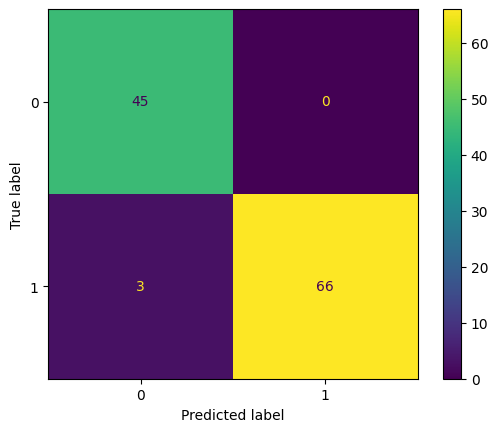

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicted_labels, x_test['target'])
ConfusionMatrixDisplay(cm).plot()
